In [ ]:
import sys
sys.path.append('/gpfs/data/fs71925/dspringer1/Projects/AnaContML/src/')
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

import torch
from torch.utils.data import DataLoader
import load_data
import datetime
from pytorch_lightning.loggers import TensorBoardLogger
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.plugins.environments import LightningEnvironment
import json
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt
# from pympler import asizeof
from scipy.optimize import curve_fit

In [2]:
def create_datasets(config):
    data = np.load(config["PATH_TRAIN"])
    train, validation = torch.utils.data.random_split(data, [int(data.__len__()*config["SPLIT"]), int(data.__len__())-int(data.__len__()*config["SPLIT"])], generator=torch.Generator().manual_seed(42))
    # print(np.asarray(train).shape)
    # x = iii
    return train, validation

# SELECT BETA FOR WHICH CTQMC DATA/FOLDERS EXIST!
beta = [10, 20, 30, 40]
    

data_dict = {}
# data_np = np.zeros((1,sort_ek.shape[0],sort_vk.shape[0],3,1000), dtype=complex)
def validate():
    ## JSON File contains full information about entire run (model, data, hyperparameters)
    MODEL_NAME = "GNN_1_base"
    config = json.load(open('/gpfs/data/fs71925/dspringer1/Projects/AnaContML/_runs/confmod_graph_neural_network_MIT_w100_n100_skew1.json'))[MODEL_NAME]
    print(config)
    config["batch_size"] = 1

    # ''' Dataloading '''
    train_data, validation_data = create_datasets(config)
    train_data = np.array(train_data)
    validation_data = np.array(validation_data)

    # ### > Single HDF5 file containing training and validation data 
    ld = __import__("load_data", fromlist=['object'])
    # data_set = load_data.Dataset_ae(config)
    train_set = getattr(ld, config["DATA_LOADER"])(config, train_data)
    validation_set = getattr(ld, config["DATA_LOADER"])(config, validation_data)
    train_dataloader = DataLoader(train_set, batch_size=config["batch_size"], shuffle=False)
    validation_dataloader = DataLoader(validation_set, batch_size=config["batch_size"], shuffle=False)

    ''' Storage '''
    t_samples = np.asarray(train_set).shape[0]
    v_samples = np.asarray(validation_set).shape[0]

    data_dict["train"] = {}
    data_dict["train"]["green"] = torch.zeros((t_samples, config["tau_steps"]))
    data_dict["train"]["prediction"] = torch.zeros((t_samples, config["omega_steps"]))
    data_dict["train"]["target"] = torch.zeros((t_samples, config["omega_steps"]))
    data_dict["train"]["p_coefficients"] = torch.zeros((t_samples, config["n_nodes"]))
    data_dict["train"]["vectors"] = torch.zeros((t_samples, config["n_nodes"], config["omega_steps"]))

    data_dict["valid"] = {}
    data_dict["valid"]["green"] = torch.zeros((v_samples, config["tau_steps"]))
    data_dict["valid"]["prediction"] = torch.zeros((v_samples, config["omega_steps"]))
    data_dict["valid"]["target"] = torch.zeros((v_samples, config["omega_steps"]))
    data_dict["valid"]["p_coefficients"] = torch.zeros((v_samples, config["n_nodes"]))
    data_dict["valid"]["vectors"] = torch.zeros((v_samples, config["n_nodes"], config["omega_steps"]))

    data_dict["ctqmc"] = {}
    for b in beta:
        data_dict["ctqmc"][b] = {}
        data_dict["ctqmc"][b]["green"] = torch.zeros((40, config["tau_steps"]))
        data_dict["ctqmc"][b]["prediction"] = torch.zeros((40, config["omega_steps"]))
        data_dict["ctqmc"][b]["p_coefficients"] = torch.zeros((40, config["n_nodes"]))
        data_dict["ctqmc"][b]["vectors"] = torch.zeros((40, config["n_nodes"], config["omega_steps"]))
        data_dict["ctqmc"][b]["U"] = torch.zeros(40)

    
    ''' Model setup '''
    wrapers = __import__("wrappers.wrapers", fromlist=['object'])#.wrapers
    model = getattr(wrapers, config["MODEL_WRAPER"])(config)

    ''' Model loading from save file '''
    if config["continue"] == True:
        SAVEPATH = config["SAVEPATH"]
        if torch.cuda.is_available():
            checkpoint = torch.load(SAVEPATH)
        else:
            checkpoint = torch.load(SAVEPATH, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint['state_dict'])
        print(" >>> Loaded checkpoint")
    
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = model.to(device)
        # model.eval()
    

    start = time.time()
    with torch.no_grad():
        
        for b in beta:
            PATH = f"/gpfs/data/fs71925/dspringer1/Projects/AnaContML/valid_scripts/gtau_beta{str(b)}_w2dyn/beta{b}/"
            gtau_ctqmc = []
            nono = []
            _ = np.load(PATH+"data.npz", allow_pickle=True)
            data = {key: _[key].item() for key in _}
            for U in data.keys():
                gtau_ctqmc.append(data[U]["gtau"][0,0,:])
                nono.append([np.zeros_like(gtau_ctqmc) + int(U)][0][0])
            gtau_ctqmc = np.array(gtau_ctqmc)
            nono = np.array(nono)            
    
            step = 10
            gtau_ctqmc = np.concatenate((
                gtau_ctqmc[:, 0][:, None],                     # first point
                gtau_ctqmc[:, step:-step:step],               # 98 intermediate points
                gtau_ctqmc[:, -1][:, None]                    # last point
            ), axis=1)
            nono = np.concatenate((
                nono[:, 0][:, None],                     # first point
                nono[:, step:-step:step],               # 98 intermediate points
                nono[:, -1][:, None]                    # last point
            ), axis=1)
            data_ctqmc = np.concatenate((gtau_ctqmc[:,None,:], nono[:,None,:]), axis=1)
            
            ctqmc_set = getattr(ld, config["DATA_LOADER"])(config, data_ctqmc)
            ctqmc_dataloader = DataLoader(ctqmc_set, batch_size=config["batch_size"], shuffle=False)
    
            for n, batch in enumerate(ctqmc_dataloader):
                # Move batch data to GPU
                batch_gpu = {}
                for k, v in batch.items():
                    if torch.is_tensor(v):
                        batch_gpu[k] = v.to(device, non_blocking=True)
                    else:
                        batch_gpu[k] = v
    
                out = model.model.forward(batch_gpu)
                data_dict["ctqmc"][b]["green"][n] = batch_gpu["node_feature"][0,0,config["omega_steps"]:]
                data_dict["ctqmc"][b]["prediction"][n] = out[0][0]
                data_dict["ctqmc"][b]["vectors"][n] = out[1][0]
                data_dict["ctqmc"][b]["p_coefficients"][n] = out[2][0,:,0]
                data_dict["ctqmc"][b]["U"][n] = batch_gpu["target"][0][0]
        print("  CTQMC DONE   ")
            
        ## TRAINING DATA
        for n, batch in enumerate(train_dataloader):
            # Move batch data to GPU
            batch_gpu = {}
            for k, v in batch.items():
                if torch.is_tensor(v):
                    batch_gpu[k] = v.to(device, non_blocking=True)
                else:
                    batch_gpu[k] = v

            out = model.model.forward(batch_gpu)            
            data_dict["train"]["green"][n] = batch_gpu["node_feature"][0,0,config["omega_steps"]:]
            data_dict["train"]["target"][n] = batch_gpu["target"]
            # data_dict["train"]["prediction"][n] = model.model.forward(batch_gpu)
            data_dict["train"]["prediction"][n] = out[0][0]
            data_dict["train"]["vectors"][n] = out[1][0]
            data_dict["train"]["p_coefficients"][n] = out[2][0,:,0]
            
            
            call_time = 1e4
            if n % call_time == 0:
                end = time.time()
                print(f"{n} / {len(train_dataloader)}    Step time: {end - start:.4f} sec")
                remaining = (len(train_dataloader) - n) * (end - start) / 60 / call_time
                print(f"Estimated time left: {remaining:.2f} minutes")
                start = time.time()

        ### VALIDATION DATA
        for n, batch in enumerate(validation_dataloader):
            # Move batch data to GPU
            batch_gpu = {}
            for k, v in batch.items():
                if torch.is_tensor(v):
                    batch_gpu[k] = v.to(device, non_blocking=True)
                else:
                    batch_gpu[k] = v

            out = model.model.forward(batch_gpu)
            data_dict["valid"]["green"][n] = batch_gpu["node_feature"][0,0,config["omega_steps"]:]
            data_dict["valid"]["target"][n] = batch_gpu["target"]
            # data_dict["valid"]["prediction"][n] = model.model.forward(batch_gpu)
            data_dict["valid"]["prediction"][n] = out[0][0]
            data_dict["valid"]["vectors"][n] = out[1][0]
            data_dict["valid"]["p_coefficients"][n] = out[2][0,:,0]
            
            call_time = 5e3
            if n % call_time == 0:
                end = time.time()
                print(f"{n} / {len(validation_dataloader)}    Step time: {end - start:.4f} sec")
                remaining = (len(validation_dataloader) - n) * (end - start) / 60 / call_time
                print(f"Estimated time left: {remaining:.2f} minutes")
                start = time.time()




def main():
    validate()

if __name__ == '__main__':
    main()



{'MODEL_NAME': 'GNN_1_base', 'MODEL_WRAPER': 'model_wraper_gnn', 'PATH_TRAIN': '/gpfs/data/fs71925/dspringer1/Projects/AnaContML/data_2025_new/w_max_10c0_w_steps_100/n_peaks_2_sigma_0c1_0c9/lambda_20c0/10000_sym_0_asym_MIT_synthetic_skewed/noise_level_0c001_noisy_samples_10/symmetric.npy', 'PATH_VEC': '/gpfs/data/fs71925/dspringer1/Projects/AnaContML/data_2025_new/ctqmc_kernels_100/lambda_200/v.npy', 'SPLIT': 0.8, 'DATA_LOADER': 'Dataset_graph_InvPro', 'continue': True, 'SAVEPATH': '/gpfs/data/fs71925/dspringer1/Projects/AnaContML/_runs/saves_MIT_w100/symmetric_100/save_GNN_1_base_BS10_2025-11-21/version_2/checkpoints/epoch=18-step=152000.ckpt', 'n_nodes': 100, 'weird': False, 'batch_size': 50, 'learning_rate': 1e-05, 'weight_decay': 1e-08, 'epochs': 20, 'omega_steps': 100, 'tau_steps': 100, 'out_dim': 100, 'message_in_dim': 400, 'message_hidden_dim': 96, 'message_out_dim': 100, 'update_hidden_dim': 96, 'update_in_dim': 400, 'update_out_dim': 200, 'pre_pool_hidden_dim': 96, 'pre_pool_o

/gpfs/data/fs71925/dspringer1/XInstalls/anaconda/envs/ml_p310/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /lib64/libc.so.6: version `GLIBC_2.32' not found (required by /gpfs/data/fs71925/dspringer1/XInstalls/anaconda/envs/ml_p310/lib/python3.10/site-packages/torch_scatter/_version_cuda.so)
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/gpfs/data/fs71925/dspringer1/XInstalls/anaconda/envs/ml_p310/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /lib64/libc.so.6: version `GLIBC_2.32' not found (required by /gpfs/data/fs71925/dspringer1/XInstalls/anaconda/envs/ml_p310/lib/python3.10/site-packages/torch_cluster/_version_cuda.so)
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/gpfs/data/fs71925/dspringer1/XInstalls/anaconda/env

 >>> Loaded checkpoint
  CTQMC DONE   
0 / 80000    Step time: 0.8185 sec
Estimated time left: 0.11 minutes
10000 / 80000    Step time: 75.8161 sec
Estimated time left: 8.85 minutes
20000 / 80000    Step time: 75.9912 sec
Estimated time left: 7.60 minutes
30000 / 80000    Step time: 76.0525 sec
Estimated time left: 6.34 minutes
40000 / 80000    Step time: 75.9969 sec
Estimated time left: 5.07 minutes
50000 / 80000    Step time: 76.0734 sec
Estimated time left: 3.80 minutes
60000 / 80000    Step time: 76.0942 sec
Estimated time left: 2.54 minutes
70000 / 80000    Step time: 76.0527 sec
Estimated time left: 1.27 minutes
0 / 20000    Step time: 76.0426 sec
Estimated time left: 5.07 minutes
5000 / 20000    Step time: 38.0732 sec
Estimated time left: 1.90 minutes
10000 / 20000    Step time: 37.9179 sec
Estimated time left: 1.26 minutes
15000 / 20000    Step time: 38.0466 sec
Estimated time left: 0.63 minutes


In [ ]:
def save_dict_to_hdf5_group(h5file, path, dictionary):
    """
    Recursively save a nested dictionary to HDF5 groups
    """
    for key, item in dictionary.items():
        key_str = str(key)
        if isinstance(item, dict):
            grp = h5file.create_group(f"{path}/{key_str}")
            save_dict_to_hdf5_group(h5file, f"{path}/{key_str}", item)
        else:
            # assume item is array-like or scalar
            h5file.create_dataset(f"{path}/{key_str}", data=np.array(item))
            
with h5py.File("GNN_1_base_MIT_skew_2025-11-21_100_bs10_v2_2.h5", "w") as f:
    save_dict_to_hdf5_group(f, "train", data_dict["train"])
    save_dict_to_hdf5_group(f, "valid", data_dict["valid"])
    save_dict_to_hdf5_group(f, "ctqmc", data_dict["ctqmc"])

In [9]:
# import numpy as np
# import h5py

PATH = "/gpfs/data/fs71925/dspringer1/Projects/AnaContML/valid_scripts/gtau_beta30_w2dyn/"

data_dict = {}
for name in os.listdir(PATH):
    if name != "data.npz":
        U = name[1:]
        data_dict[U] = {}
        for file in os.listdir(PATH+name):
            # Open file
            if "oo_9" in file:
                f = h5py.File(PATH+name+"/"+file, "r")
                data_dict[U]["gtau"] = np.array(f['dmft-last']['ineq-001']['gtau']['value'])
                data_dict[U]["giv"] = np.array(f['dmft-last']['ineq-001']['giw']['value'])
                data_dict[U]["siv"] = np.array(f['dmft-last']['ineq-001']['siw']['value'])
                data_dict[U]["occ"] = np.array(f['dmft-last']['ineq-001']['occ']['value'])

                print(data_dict[U]["gtau"].shape)
# Save (assumes dict values are arrays)
np.savez(PATH+"data.npz", **data_dict)

NotADirectoryError: [Errno 20] Not a directory: '/gpfs/data/fs71925/dspringer1/Projects/AnaContML/valid_scripts/gtau_beta30_w2dyn/Create_Parametersin_worm'

In [ ]:
# Load
data = np.load(PATH+"data.npz", allow_pickle=True)
my_dict = {key: data[key].item() for key in data}
print(my_dict["10"].keys())



In [ ]:
gtau_ctqmc = []
nono = []

_ = np.load(PATH+"data.npz", allow_pickle=True)
data = {key: _[key].item() for key in _}
for U in data.keys():
    gtau_ctqmc.append(data[U]["gtau"][0,0,:])
    nono.append([np.zeros_like(gtau_ctqmc) + int(U)][0][0])

gtau_ctqmc = np.array(gtau_ctqmc)
nono = np.array(nono)


In [ ]:
beta = [30]
for b in beta:
    PATH = f"/gpfs/data/fs71925/dspringer1/Projects/AnaContML/valid_scripts/gtau_beta{str(b)}_w2dyn/data/"
    gtau_ctqmc = []
    nono = []
    _ = np.load(PATH+"data.npz", allow_pickle=True)
    data = {key: _[key].item() for key in _}
    for U in data.keys():
        gtau_ctqmc.append(data[U]["gtau"][0,0,:])
        nono.append([np.zeros_like(gtau_ctqmc) + int(U)][0][0])
    gtau_ctqmc = np.array(gtau_ctqmc)
    nono = np.array(nono)            

    print(gtau_ctqmc.shape)
    step = 10
    gtau_ctqmc = np.concatenate((
        gtau_ctqmc[:, 0][:, None],                     # first point
        gtau_ctqmc[:, step:-step:step],               # 98 intermediate points
        gtau_ctqmc[:, -1][:, None]                    # last point
    ), axis=1)
    nono = np.concatenate((
        nono[:, 0][:, None],                     # first point
        nono[:, step:-step:step],               # 98 intermediate points
        nono[:, -1][:, None]                    # last point
    ), axis=1)
    data_ctqmc = np.concatenate((gtau_ctqmc[:,None,:], nono[:,None,:]), axis=1)
    
    ctqmc_set = getattr(ld, config["DATA_LOADER"])(config, data_ctqmc)
    ctqmc_dataloader = DataLoader(ctqmc_set, batch_size=config["batch_size"], shuffle=False)

    for n, batch in enumerate(ctqmc_dataloader):
        # Move batch data to GPU
        batch_gpu = {}
        for k, v in batch.items():
            if torch.is_tensor(v):
                batch_gpu[k] = v.to(device, non_blocking=True)
            else:
                batch_gpu[k] = v

        out = model.model.forward(batch_gpu)
        data_dict["ctqmc"][b]["green"][n] = batch_gpu["node_feature"][0,0,config["omega_steps"]:]
        data_dict["ctqmc"][b]["prediction"][n] = out[0][0]
        data_dict["ctqmc"][b]["vectors"][n] = out[1][0]
        data_dict["ctqmc"][b]["p_coefficients"][n] = out[2][0,:,0]
        data_dict["ctqmc"][b]["U"][n] = batch_gpu["target"][0][0]
print("  CTQMC DONE   ")

In [ ]:
# data_dict = h5py.File("GNN_1_base_MIT_2025-11-17_100_bs10_v1.h5", "r")
# print(data_dict.keys())

# data_dict_max_1 = h5py.File("maxent_data_100_b.h5", "r")
# data_dict_max_2 = h5py.File("maxent_data_100_c.h5", "r")
# print(data_dict_max_1.keys())
# print(data_dict_max_2.keys())


In [ ]:
# import numpy as np
# import os

# PATH = "/gpfs/data/fs71925/dspringer1/Projects/AnaContML/valid_scripts/gtau_beta20_w2dyn/"
# occ = []
# gtau_ctqmc = []
# siv_ctqmc = []

# for name in os.listdir(PATH):
#     # Open file
#     if name[0]=="U":
#         U = int(name[1:])//10
#         # print(PATH+name)
#         data = np.loadtxt(PATH+name+"/occ.dat", comments="#", usecols=6)
#         occ.append([U,data])

#         data = np.loadtxt(PATH+name+"/gtau.dat", comments="#", usecols=5)
#         # Extract 6th column (index 5 in Python)
#         gtau_ctqmc.append(data)

#         data = np.loadtxt(PATH+name+"/siw.dat", comments="#", usecols=6)
#         # Extract 6th column (index 5 in Python)
#         siv_ctqmc.append(data)

# occ = np.array(occ)
# perm = np.argsort(occ[:,0])
# gtau_ctqmc = np.array(gtau_ctqmc)
# gtau_ctqmc = gtau_ctqmc[perm]
# siv_ctqmc = np.array(siv_ctqmc)
# siv_ctqmc = siv_ctqmc[perm]
# occ = occ[perm]
# print(siv_ctqmc.shape)

# fig, ax1 = plt.subplots(figsize=(8,6))

# # left y-axis
# ax1.plot(occ[:,0], occ[:,1], label="occ")
# ax1.plot(occ[:,0], gtau_ctqmc[:,500], label="gtau_ctqmc")
# ax1.set_xlabel("x")   # replace if you want
# ax1.set_ylabel("occ / gtau")

# # right y-axis
# ax2 = ax1.twinx()
# ax2.plot(occ[:,0], siv_ctqmc[:], color="green", label="siv_ctqmc", linestyle="-")
# ax2.set_ylabel("siv")

# # one combined legend
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

# plt.tight_layout()
# plt.show()

In [ ]:
# import matplotlib.pyplot as plt
# t_samples = data_dict["train"]["target"].shape[0]
# v_samples = data_dict["valid"]["target"].shape[0]
# n_t = int(np.random.rand()*t_samples)
# n_v = int(np.random.rand()*v_samples)

# print(n_t, n_v)
# # n_t = 50587     #980 
# # n_v = 19456  #288

# fig, ax = plt.subplots(ncols=2, figsize=(12,8))

# ax[0].plot(data_dict["train"]["target"][n_t])
# ax[0].plot(data_dict["train"]["prediction"][n_t])
# ax[1].plot(data_dict["valid"]["target"][n_v])
# ax[1].plot(data_dict["valid"]["prediction"][n_v])


In [ ]:
# t_coeff = []
# data_dict["train"]["t_coefficients"] = torch.zeros((t_samples, 100))
# for t in range(t_samples):
#     for n in range(100):
#         data_dict["train"]["t_coefficients"][t,n] = data_dict["train"]["target"][t] @ data_dict["train"]["vectors"][t][n]

In [ ]:
# from scipy.ndimage import gaussian_filter1d

# t = int(np.random.rand()*7999) #7121
# print(t)
# A = data_dict["train"]["target"][t]
# A = A / torch.sum(A)
# A_t = torch.zeros(data_dict["train"]["vectors"].shape[2])
# A_p = torch.zeros(100,data_dict["train"]["vectors"].shape[2])
# for n in range(100):
#     A_t += data_dict["train"]["t_coefficients"][t,n] * data_dict["train"]["vectors"][t,n]
#     for m in range(n):
#         A_p[n] += data_dict["train"]["p_coefficients"][t,m] * data_dict["train"]["vectors"][t,m]
#     A_p[n] = A_p[n] / torch.sum(A_p[n])
# A_p_a = torch.sum(A_p, axis=0)/n

# A_gauss = gaussian_filter1d(A_p[n], sigma=4.0)
# A_gauss = A_gauss / np.sum(A_gauss)
# A_t = A_t / torch.sum(A_t)
# A_t_gauss = A_gauss / np.sum(A_gauss)

# fig, ax = plt.subplots(ncols=2, figsize=(12,6))
# ax[0].plot(data_dict["train"]["t_coefficients"][t,:])
# ax[0].plot(data_dict["train"]["p_coefficients"][t,:])
# ax[1].plot(A)
# ax[1].plot(A_t)
# ax[1].plot(A_p[n])


# A_p_a = torch.sum(A_p, axis=0)/n
# fig, ax = plt.subplots(ncols=2, figsize=(12,6))
# ax[0].plot(A)
# ax[0].plot(A_t)
# ax[0].plot(A_p[n])
# ax[1].plot(A)
# ax[1].plot(A_gauss)


In [ ]:
# def create_datasets(config):
#     data = np.load(config["PATH_TRAIN"])
#     train, validation = torch.utils.data.random_split(data, [int(data.__len__()*config["SPLIT"]), int(data.__len__())-int(data.__len__()*config["SPLIT"])], generator=torch.Generator().manual_seed(42))
#     # print(np.asarray(train).shape)
#     # x = iii
#     return train, validation


# data_dict = {}
# # data_np = np.zeros((1,sort_ek.shape[0],sort_vk.shape[0],3,1000), dtype=complex)
# def validate():
#     ## JSON File contains full information about entire run (model, data, hyperparameters)
#     MODEL_NAME = "GNN_1_base"
#     config = json.load(open('/gpfs/data/fs71925/dspringer1/Projects/AnaContML/_runs/confmod_graph_neural_network_MIT_w100_n100.json'))[MODEL_NAME]
#     print(config)

#     # ### > Single HDF5 file containing training and validation data 
#     ld = __import__("load_data", fromlist=['object'])
#     data_dict["ctqmc"] = {}
#     data_dict["ctqmc"]["green"] = torch.zeros((40, config["tau_steps"]))
#     data_dict["ctqmc"]["prediction"] = torch.zeros((40, config["omega_steps"]))
#     data_dict["ctqmc"]["p_coefficients"] = torch.zeros((40, config["n_nodes"]))
#     data_dict["ctqmc"]["vectors"] = torch.zeros((40, config["n_nodes"], config["omega_steps"]))
#     data_dict["ctqmc"]["U"] = torch.zeros(40)


#     start = time.time()
#     with torch.no_grad():
        
#         ## CTQMC DATA
#         PATH = "/gpfs/data/fs71925/dspringer1/Projects/AnaContML/valid_scripts/gtau_beta20_w2dyn/"
#         gtau_ctqmc = []
#         nono = []
#         for name in os.listdir(PATH):
#             # Open file
#             if name[0]=="U":
#                 U = int(name[1:])//10
#                 # print(PATH+name)
#                 data = np.loadtxt(PATH+name+"/gtau.dat", comments="#", usecols=5)
#                 # Extract 6th column (index 5 in Python)
#                 gtau_ctqmc.append(data)
#                 nono.append(np.zeros_like(data) + U)
                
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#         gtau_ctqmc = np.array(gtau_ctqmc)
#         nono = np.array(nono)
#         step = 10
#         gtau_ctqmc = np.concatenate((
#             gtau_ctqmc[:, 0][:, None],                     # first point
#             gtau_ctqmc[:, step:-step:step],               # 98 intermediate points
#             gtau_ctqmc[:, -1][:, None]                    # last point
#         ), axis=1)
#         nono = np.concatenate((
#             nono[:, 0][:, None],                     # first point
#             nono[:, step:-step:step],               # 98 intermediate points
#             nono[:, -1][:, None]                    # last point
#         ), axis=1)
#         data_ctqmc = np.concatenate((gtau_ctqmc[:,None,:], nono[:,None,:]), axis=1)
        
#         ctqmc_set = getattr(ld, config["DATA_LOADER"])(config, data_ctqmc)
#         ctqmc_dataloader = DataLoader(ctqmc_set, batch_size=config["batch_size"], shuffle=False)

#         plt.figure(1)
#         for n, batch in enumerate(ctqmc_dataloader):
#             # Move batch data to GPU
#             batch_gpu = {}
#             for k, v in batch.items():
#                 if torch.is_tensor(v):
#                     batch_gpu[k] = v.to(device, non_blocking=True)
#                 else:
#                     batch_gpu[k] = v
#             plt.plot(batch_gpu["node_feature"][0,0,100:].detach().cpu())
#             # break

        

# def main():
#     validate()

# if __name__ == '__main__':
#     main()

(9, 1000)
(6, 1000)
(6, 1000)


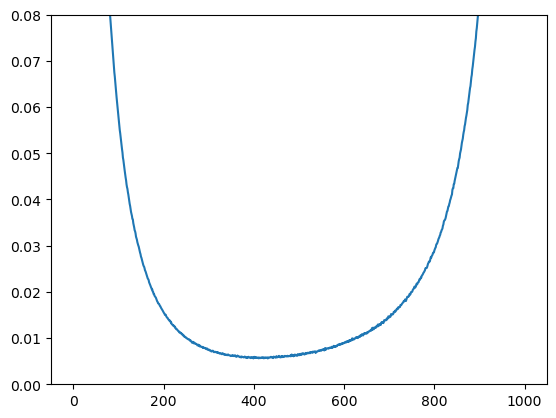

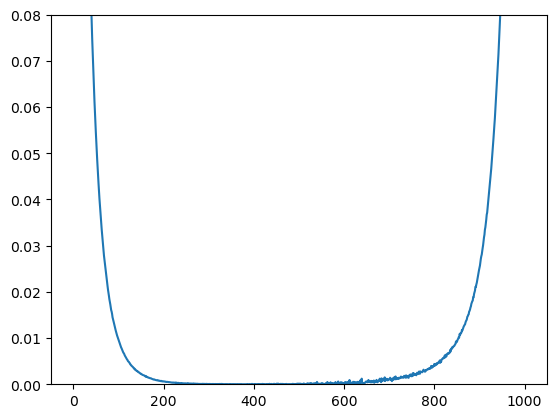

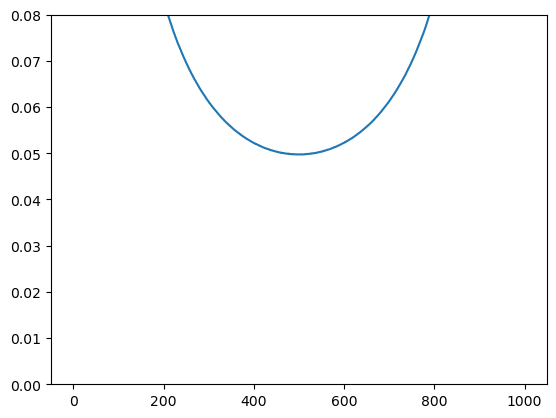

In [8]:
beta = [20,30,40]
for b in beta:
    PATH = f"/gpfs/data/fs71925/dspringer1/Projects/AnaContML/valid_scripts/gtau_beta{str(b)}_w2dyn/data/"
    gtau_ctqmc = []
    nono = []
    _ = np.load(PATH+"data.npz", allow_pickle=True)
    data = {key: _[key].item() for key in _}
    for U in data.keys():
        gtau_ctqmc.append(data[U]["gtau"][0,0,:])
        nono.append([np.zeros_like(gtau_ctqmc) + int(U)][0][0])
    gtau_ctqmc = np.array(gtau_ctqmc)
    print(gtau_ctqmc.shape)

    plt.figure(b)
    plt.plot(gtau_ctqmc[0])
    plt.ylim([0,0.08])